In [6]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import minimize
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from itertools import chain

import warnings
warnings.filterwarnings("ignore")
import os
if not os.path.exists('plots/'):
    os.mkdir('plots')


In [7]:
# Define variables 
Eps         = 8.85e-12               # Vacuum permittivity(coloum^2/Jm)         
T           = 300                    # Tempreture (kelvin)
Kb          = 1.38*1e-23             # Boltzmann Constant (J/kelvin)
Dw          = 80                     # Water dielectric constant
NA          = 6.023*1e+23            # Avagadro's number
V           = 1e27                   # Total volume in (A^3) 
ele         = 1.6e-19                # Electron Charge
lb          = ele**2*1e10/(4*np.pi*Eps*Dw*Kb*T)   # Bejurium Length in meter (A)
V           = 1e27                   # Total volume in (A^3) 
KA          = 0.578                  # Stretch Modulus (KbT/A^2)

# Melittin or LL-37 peptide parameter
A_p         = 400                    # Area of peptide (A^2)
vp          = 33**3                  # volume of peptide in bulk A^3 
Q           = 6                      # Peptide charge for peptide LL-37
a0          = 71                     # Lipid area or Surface area per lipid

# Salt concentration Mol to Debye Length conversion

In [8]:

def kp(n1,n2):  # Debye length conversion (monovalent + divalent Ions)
    # n1: monovalent (molar),n2: divalent (molar)
    convMg = 0.602 *10**(-3)                      #  convert Molar to molecules/A**3
    convNa = 0.602 *10**(-3)                      #  convert Molar to molecules/A**3
    n1, n2 = n1*convNa, n2*convMg 
    return np.sqrt(4 *np.pi *lb*(2*n1 + (2**2 + 2)* n2)) #  Inverse Debye length (A) 

def Dell(n1,n2): return 2 * (1/40 + kp(n2) *40)/(2/40 + kp(n2) * 40)/10  #  Dielectric discontinuity  

# Experimental data for NaCl and MIC 
NaCl_initial = [0.5 ,1.0, 1.5, 2.0, 2.5] # units [100mM]
MIC_NaCl = [ 1.12, 1.25, 1.62 ,1.75, 2 ] # units [µM]
NaCl_M =  [i*0.1 for i in NaCl_initial]  # units [M]
NaCl_mM = [i*100 for i in NaCl_initial]  # units [mM]

Mg_range = [5e-6 for _ in range(len(NaCl_M))] # units [M]

kappa_range=[]
for i,nacl in enumerate(NaCl_M):
    n1,n2 = nacl, Mg_range[i]
    kappa = kp(n1, n2)
    kappa_range.append(kappa)


# Minimization method 

In [16]:
# Minimization method applied 
#Linearilzed PB equation (\phi<<1)

f_A = 0.59# Fraction of anionic lipids

def competeE(x):

    sig_p, sig_1, sig_2  = x[0], x[1], x[2]

    # Free energy 1-3: electrostatic energy terms
    # Free energy 1. Bound state of the peptides
    sig_net = (Q*sig_p) + sig_1 + 2*sig_2 - (f_A/a0)
    phi_0   = 2*(2*np.pi*lb*sig_net)/kappa
    f_el_S  = (sig_net *phi_0) # -((kappa/(np.pi*lb))*((1+(phi_small**2)/2)-1)) 

    # Free energy 2. Unbound state of the peptides
    sig_0    = -(f_A/a0)
    phi_00   = 2* (2*np.pi*lb*sig_0)/kappa
    f_el_S_0 = (sig_0 *phi_00 )# - ((kappa/(np.pi*lb))*((1+(phi_small_00**2)/2)-1))

    # Free energy 3. Free peptides in the solution
    r0      = 15   #radius of the peptide ([A] Angstrom)
    lambda2 = 0.126 # lambda2 = e^2/(4*eps*r0*kT)
    lambda3 = kappa*r0
    f_el_L = (2*Q**2*lambda2)/(1+lambda3)
#     f_el_L = (2*np.pi*Q**2 *lb)/(1+lambda3)/r0
    hydrophobic_E = -9 #in the unit of KbT 
    
    delF = f_el_S - f_el_S_0 - f_el_L*sig_p + hydrophobic_E*sig_p 
    
    # Entropic terms: 
    r1,r2 = 3.4,4.3;
    Ent_p = sig_p*np.log((sig_p*A_p)/(Cp*vp))-sig_p 
    Ent_1 = sig_1*np.log((sig_1*np.pi*r1**2)/(C1*3/4*np.pi*r1**3))-sig_1
    Ent_2 = sig_2*np.log((sig_2*np.pi*r2**2)/(C2*3/4*np.pi*r2**3))-sig_2

    return  delF + Ent_p + Ent_1+ Ent_2
    

def free_energy(Cp, Ct, C1, C2, X0):
    
    # free_energy minimize 
    
    # Cp: Bulk concentration of peptides
    # Ct: Bulk concentration of cells
    # C1, C2: Bulk concentration ions Na+ and Mg2+ respectively 
    # X0: initial guess for charge density values X0=[x1,x2,x3](=sig_p, sig_1, sig_2)
    
    bnds = [(0, 0.01),(0,1),(0, 1)]
    tolerance= 1e-12
    solution = minimize(competeE,X0, tol=tolerance, method = 'SLSQP',bounds =bnds)
    
    x = solution.x
    x1,x2,x3= x[0],x[1],x[2]
    return x1,x2,x3


def binding_E_wB(MIC ,CB, P_LI):
    # This function return binding energy for bacteria cell
    NA = 6.023*1e+23;           # Avagadro's number
    vp = 33**3;                 # Melittin random coil's volume
    Ap_ent = 400;               # Physical Area per peptide
    TresholdB = P_LI
    Ab = 2*6e-12*1e20           # Surface area of bacterium's membrane(twice of E-coli) (m^2*1e20 = A^2)
    alb = 71
    # Calculate Langmuir-like binding energy from one data set (MIC_Ct0 , Ct0_B) of full analysis
    MIC_Ct0 = MIC*((1e-6)*NA*(1e-27));
    wB = np.log((MIC_Ct0 - Ab/alb*TresholdB*CB)* vp*(1-Ap_ent/alb*TresholdB)/(Ap_ent/alb*TresholdB))
    return wB



# Find Binding Energy & Map to Langmuir Model

MIC: Kappa =  0.07252146410224852 Cp =  0.6250551925273976  P/L =  0.09997213588035085  W_b =  -11.464912642593587
 sig_p = 0.0014080582518359276  sig1 = 4.888930156068428e-05  sig2 = 1.2820005113840061e-17

MIC: Kappa =  0.10255314805232198 Cp =  0.9540954763499944  P/L =  0.0998411888009691  W_b =  -11.03899039282724
 sig_p = 0.0014134410550844573  sig1 = 4.5592961002741414e-05  sig2 = 2.028073626625428e-18

MIC: Kappa =  0.12559830251778573 Cp =  1.4563484775012443  P/L =  0.09983349737062097  W_b =  -10.615890422931717
 sig_p = 0.0014187887938464808  sig1 = 4.250985677856906e-05  sig2 = 1.2074077680969412e-16

MIC: Kappa =  0.14502661485140225 Cp =  2.2229964825261956  P/L =  0.10000745011027165  W_b =  -10.196949728082346
 sig_p = 0.001424102930930782  sig1 = 3.963070326396724e-05  sig2 = 2.230116479975363e-17

MIC: Kappa =  0.1621434686787128 Cp =  3.39322177189533  P/L =  0.1003656634696321  W_b =  -9.782234628648434
 sig_p = 0.001429381029082441  sig1 = 3.697063014578329e-05  s

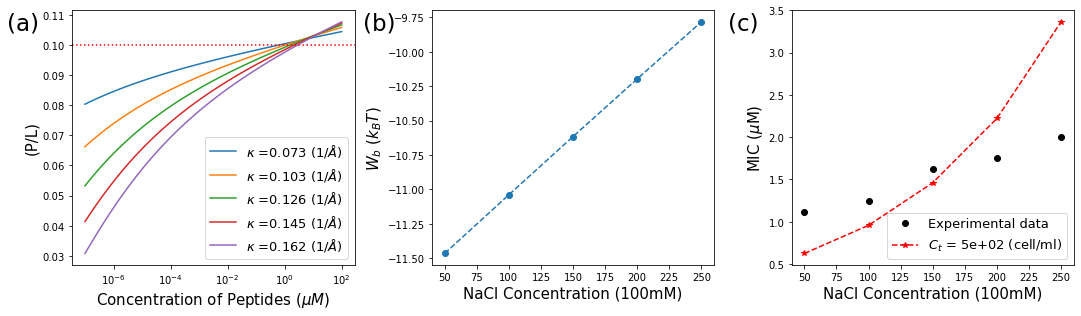

In [17]:
# Find Binidng Energy: 
Cp_range = np.logspace(-7,2, num=50) #Bulk concentration peptides range 
PL_B = 0.1 # Threshold value
X0 = [0.001,1e-5,1e-5]

BE_wB   = []
MIC_save = {'kappa': [], 'Cp':[],'Ct':[], 'P/L':[],'W_b':[],'x1':[],'x2':[],'x3':[]}

x1_list=[]
x2_list=[]
x3_list=[]
sig_p_list = []
sig_1_list = []
sig_2_list = []

plt.figure(figsize=(15,4.5))

ax1 = plt.subplot(1,3,1)
for i,kappa in enumerate(kappa_range):
    Ct_cell = 1*10**(2)
    C1_val = NaCl_M[i]
    C2_val = Mg_range[i]
    P_LI    = []
    for Cp_val in Cp_range:
        Cp = Cp_val*((1e-6)*NA*(1e-27))
        Ct = Ct_cell *1e-24
        C1 = C1_val*(1*NA*(1e-27))
        C2 = C2_val*(1*NA*(1e-27))
        x1,x2,x3= free_energy(Cp, Ct, C1, C2, X0)
        P_LI.append(x1*a0)
        x1_list.append(x1)
        x2_list.append(x2)
        x3_list.append(x3)
    P_LI = np.asarray(P_LI)
    idx = (np.abs(P_LI - PL_B)).argmin()
    W_b = binding_E_wB(Cp_range[idx] ,Ct, P_LI[idx])
    BE_wB.append(W_b)
    sig_p = x1_list[idx]
    sig_1 = x2_list[idx]
    sig_2 = x3_list[idx]
    sig_1_list.append(sig_1)
    sig_2_list.append(sig_2)
    print('MIC: Kappa = ',kappa ,'Cp = ',Cp_range[idx],' P/L = ',P_LI[idx], ' W_b = ',W_b)
    print(' sig_p =', sig_p, ' sig1 =', sig_1, ' sig2 =', sig_2)
    print()

    MIC_save['kappa'].append(kappa)
    MIC_save['Cp'].append(Cp_range[idx])
    MIC_save['Ct'].append(Ct_cell)
    MIC_save['P/L'].append(P_LI[idx])
    MIC_save['W_b'].append(W_b)

    plt.plot(Cp_range,P_LI,label=r'$\kappa$ =%1.3f $(1/{\AA})$'%kappa)    
plt.xscale('log')
plt.axhline(y=PL_B, color='r', linestyle=':')
plt.ylabel('(P/L)', fontsize = 15)
plt.xlabel('Concentration of Peptides ($\mu M$)', fontsize = 15)
plt.legend( fontsize = 13)    
plt.text(-0.23,.925,"(a)",fontsize=23, transform=ax1.transAxes)
    
ax2 = plt.subplot(1,3,2)
plt.plot(NaCl_mM,BE_wB,'--o')
plt.xlabel('NaCl Concentration (100mM)' , fontsize = 15)
plt.ylabel('$W_b$ $(k_B T)$', fontsize = 15)
plt.text(-0.245,.925,"(b)",fontsize=23, transform=ax2.transAxes)


# Langmuir model mapping
A_p = 400           # Amstrong square
v_p = 33**3         # Amstrong cubic
A_B = 400           # Amstrong square (Surface area of each cells)
A_H = A_B           # Amstrong square
a_B = 71            # Amstrong square (Area of each lipids)
a_H = 74            # Angstrom square 
A_t = 12*10**8      # Ah and Ab
At  = 12*10**8       # Ah and Ab

# Preliminary Constant values
avo_con = 6.023*10**23 #Avogadro constant
mu_M_unit = 10**-6*avo_con *10**-27 
unit =10**-24 #(unit conversion)

def MIC_non_competitive_membrane(CB, w_B, PL_B):    

    MIC_0 = 1/v_p* A_B/a_B * PL_B /(1-  A_B/a_B * PL_B)*(np.exp(w_B))
    eq1   = (PL_B*At/a_B ) *CB*unit +  MIC_0
    Cp    = eq1/mu_M_unit
    
    return Cp

# Combine Sattar's Data at different salt concentrations:
ax3 = plt.subplot(1,3,3)

plt.plot(NaCl_mM, MIC_NaCl,'o',label='Experimental data',color='k')

CB_range = [5*10**(i) for i in range(2,3,2)]
for CB in CB_range: 
    MIC_values=[]
    for i, w_B in enumerate(MIC_save['W_b']):
        MIC_values.append(MIC_non_competitive_membrane(CB,w_B,PL_B))
    plt.plot(NaCl_mM, MIC_values,'--',label=r'$C_t$ = %1.0e (cell/ml)'%(CB), marker='*',color='red')
    plt.xlabel('NaCl Concentration (100mM)' , fontsize = 15)
    plt.ylabel('MIC ($\mu$M)', fontsize = 15)
plt.legend( fontsize = 13,loc='lower right')    
plt.text(-0.225,.925,"(c)",fontsize=23, transform=ax3.transAxes)    
    
plt.tight_layout()
plt.savefig('plots/'+('Outer_layer_PL_01_minimization')+'.pdf',bbox_inches='tight')




In [23]:
print('sig_p = ',sig_p,'  sig_1 = ',sig_1,'  sig_2 = ',sig_2)
print('sig_0*0.1 = ',(f_A/a0)*0.1)
print('sig_net   = ',(Q*x1) + sig_1 + 2*sig_2 - (f_A/a0))

sig_p =  0.001429381029082441   sig_1 =  3.697063014578329e-05   sig_2 =  3.4439433335892325e-18
sig_0*0.1 =  0.0008309859154929577
sig_net   =  0.0008252819812334285
